### Základy neurónových sietí STU FIIT
## Credit Risk Assessment


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/dataset.csv")
pd.set_option('display.max_columns', 21)

### Data Analysis

In [2]:
print("=====SHAPE=====")
df.shape



=====SHAPE=====


(1000, 21)

In [3]:
print("=====HEAD=====")
df.head()


=====HEAD=====


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,4,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,2,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,3,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,4,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,4,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [4]:
print("=====TAIL=====")
df.tail()

=====TAIL=====


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
995,'no checking',12,'existing paid',furniture/equipment,1736,'<100','4<=X<7',3,'female div/dep/mar',none,4,'real estate',31,none,own,1,'unskilled resident',1,none,yes,good
996,'<0',30,'existing paid','used car',3857,'<100','1<=X<4',4,'male div/sep',none,4,'life insurance',40,none,own,1,'high qualif/self emp/mgmt',1,yes,yes,good
997,'no checking',12,'existing paid',radio/tv,804,'<100','>=7',4,'male single',none,4,car,38,none,own,1,skilled,1,none,yes,good
998,'<0',45,'existing paid',radio/tv,1845,'<100','1<=X<4',4,'male single',none,4,'no known property',23,none,'for free',1,skilled,1,yes,yes,bad
999,'0<=X<200',45,'critical/other existing credit','used car',4576,'100<=X<500',unemployed,3,'male single',none,4,car,27,none,own,1,skilled,1,none,yes,good


In [5]:
print("=====DTYPE=====")
df.dtypes

=====DTYPE=====


checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

In [6]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [7]:
df.isna().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

In [8]:
df.loc[df.duplicated()]

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class


In [9]:
num_cols = df.select_dtypes(include=['number']).columns
cat_cols = df.select_dtypes(exclude=['number']).columns

print("Numeric columns:\n", list(num_cols))
print("\nCategorical columns:\n", list(cat_cols))

Numeric columns:
 ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']

Categorical columns:
 ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'class']


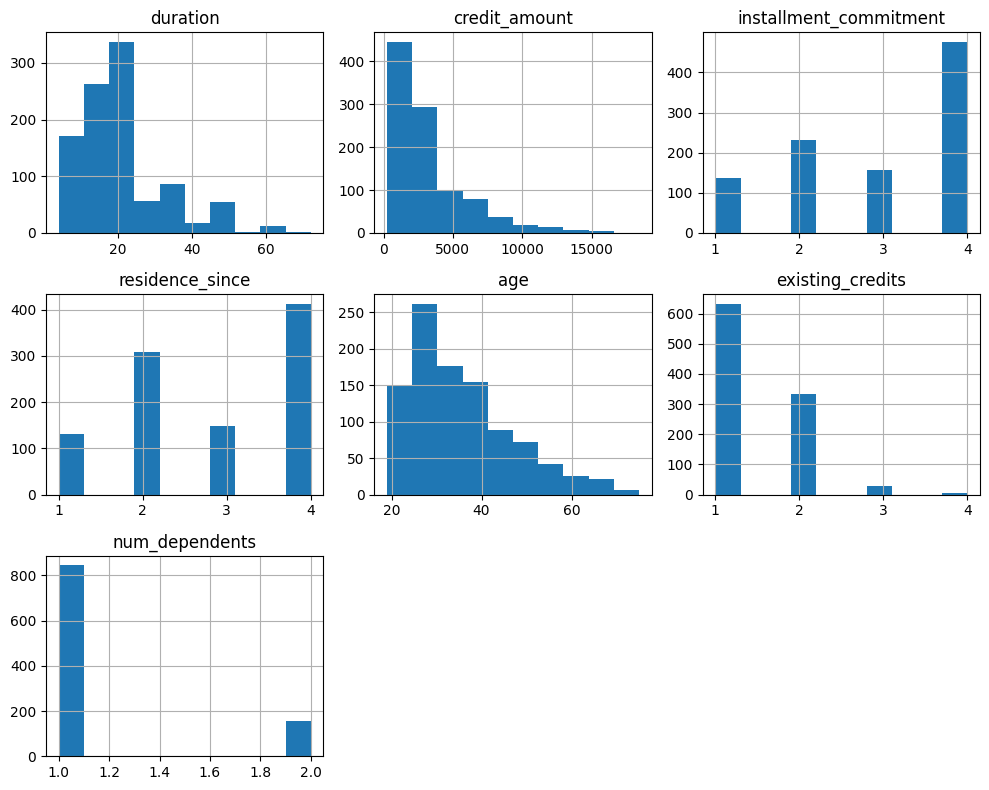

In [10]:
df[num_cols].hist(figsize=(10,8))
plt.tight_layout()
plt.show()

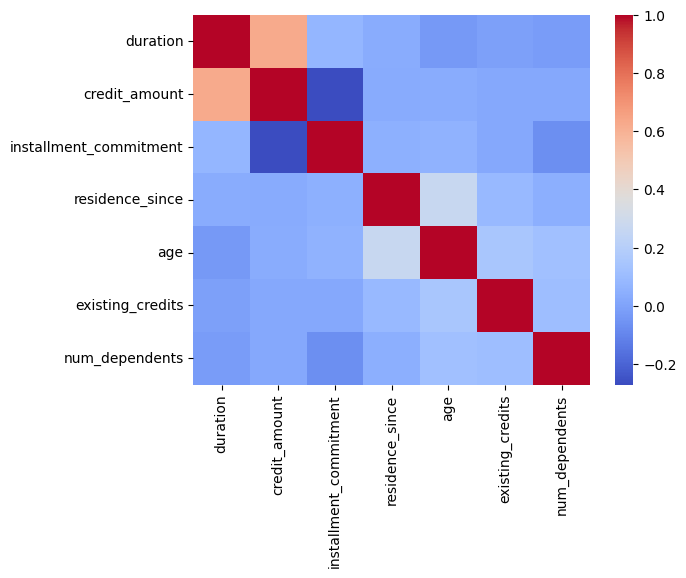

In [13]:
sns.heatmap(df[num_cols].corr(), cmap="coolwarm")
plt.show()


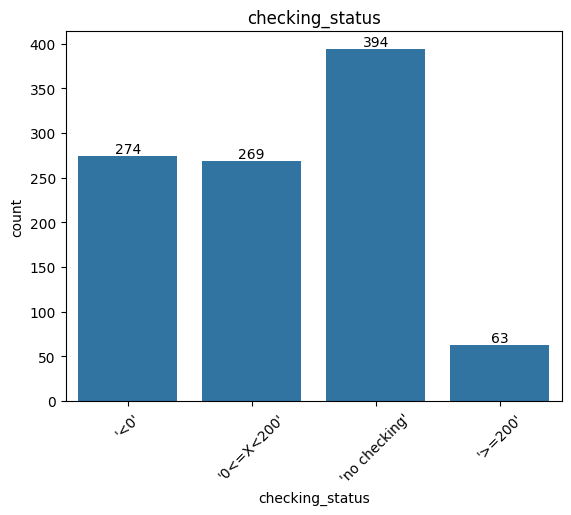

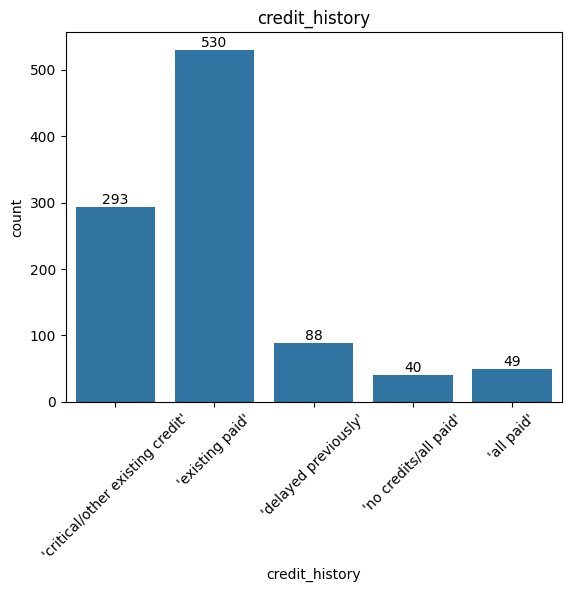

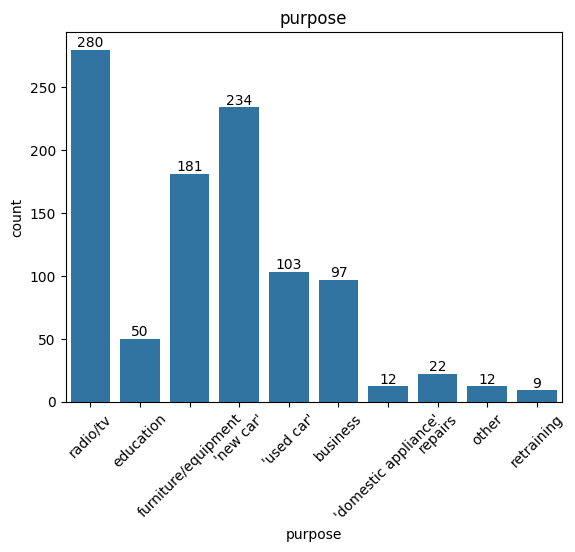

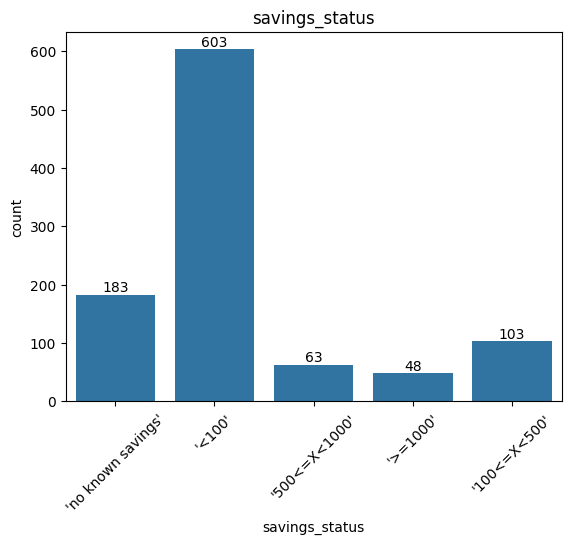

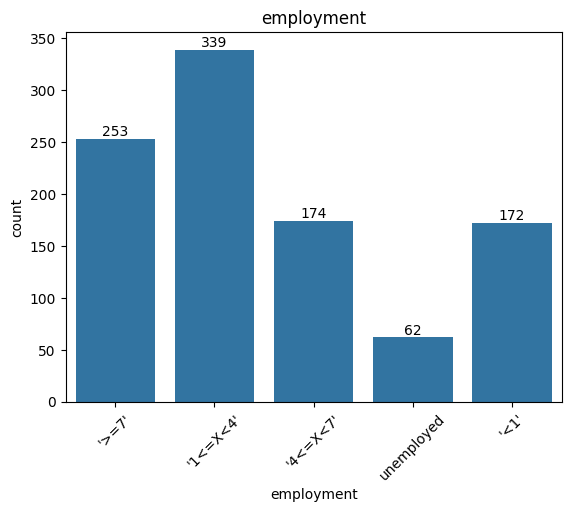

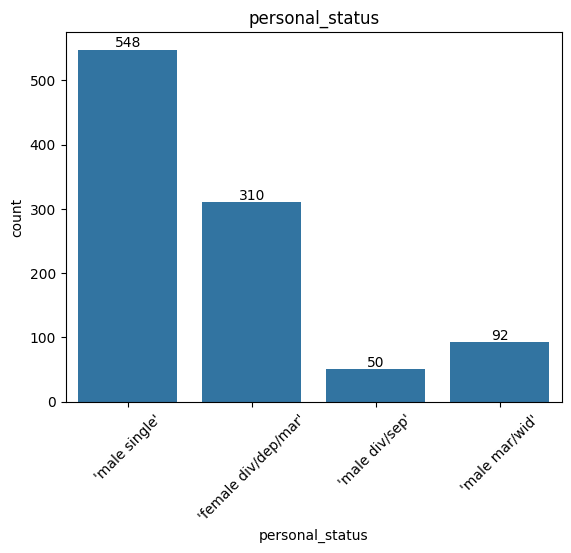

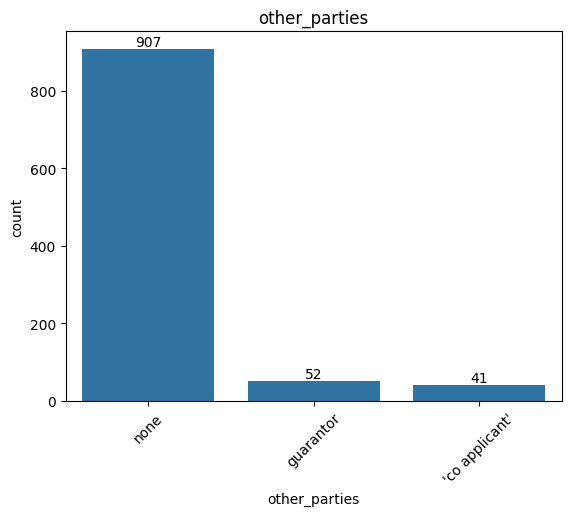

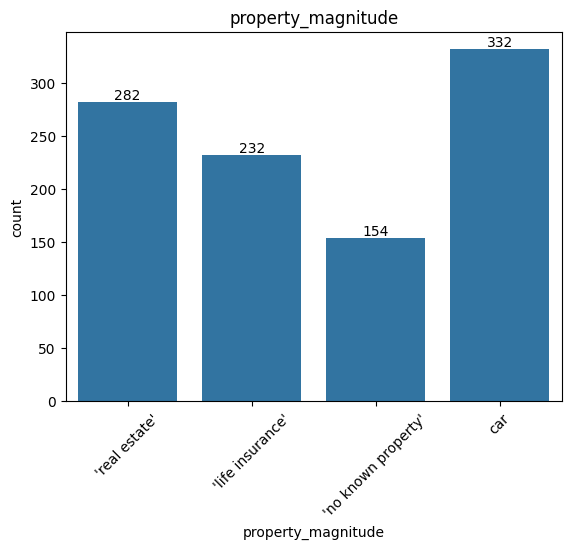

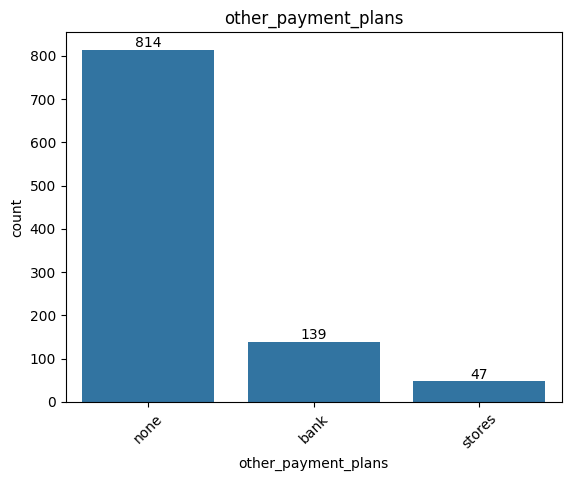

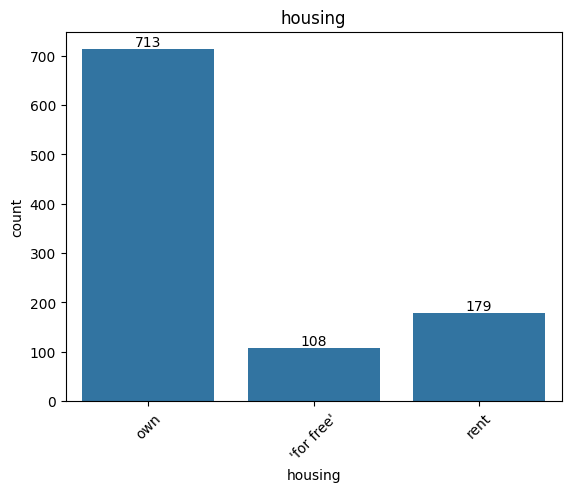

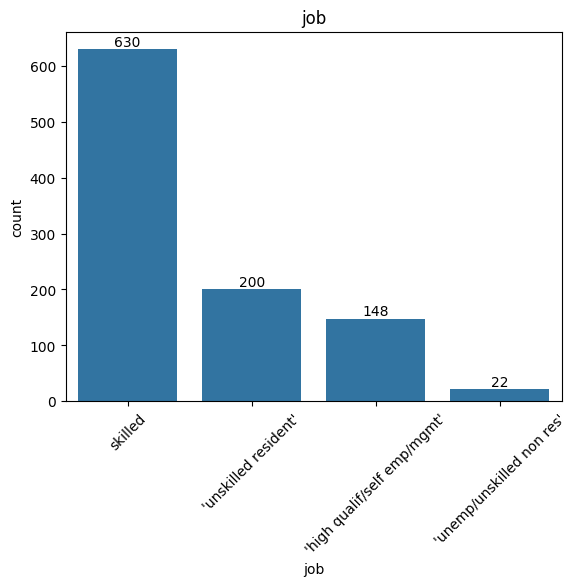

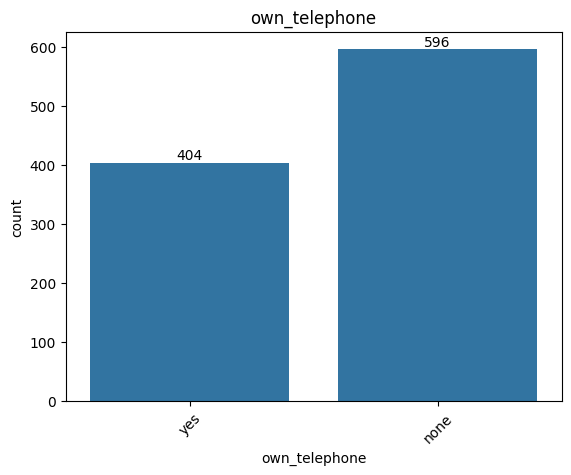

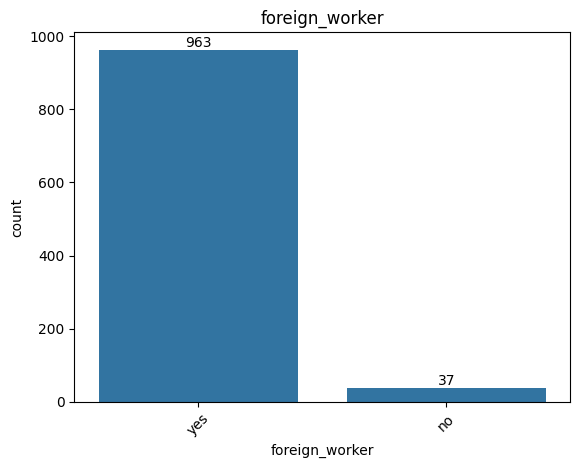

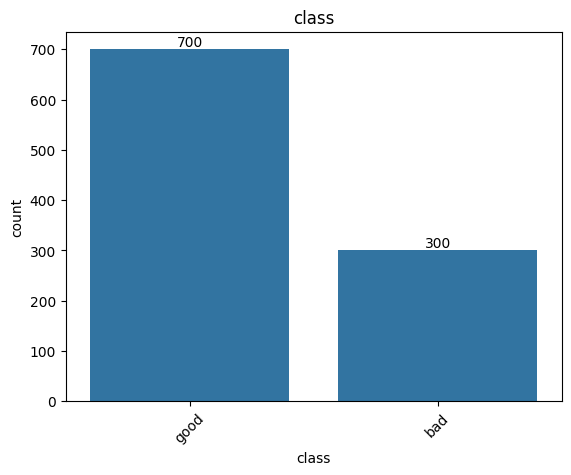

In [16]:
cat_cols = df.select_dtypes(exclude=['number']).columns

for c in cat_cols:
    ax = sns.countplot(x=c, data=df)
    plt.title(c)
    plt.xticks(rotation=45)

    for container in ax.containers:
        ax.bar_label(container)

    plt.show()

